In [1]:
"""
Gym Churn Prediction — Pipeline ML (Clean Architecture)
======================================================

Ce bloc exécute l'intégralité du pipeline ML :
1. Chargement des données
2. Préprocessing métier
3. Feature engineering avancé
4. Entraînement d'un modèle CatBoost
5. Production d'un artifact de modèle

Tout est volontairement regroupé dans une seule cellule
pour faciliter l'exécution dans un notebook.
"""

# ======================================================
# 1. IMPORTS — séparation claire des couches
# ======================================================

# --- Infrastructure : implémentations concrètes ---
from churn_gym.infrastructure.data_sources.csv_loader_pandas import PandasCSVLoader
from churn_gym.infrastructure.ml.preprocessing.preprocessing_pipeline import BasicPreprocessingPipeline
from churn_gym.infrastructure.ml.features.advanced_feature_engineering import AdvancedFeatureEngineeringPipeline
from churn_gym.infrastructure.ml.models.catboost_classifier import CatBoostTrainer

# --- Application : use cases métier ---
from churn_gym.application.use_cases.load_dataset import LoadDatasetUseCase
from churn_gym.application.use_cases.preprocess_dataset import PreprocessDatasetUseCase
from churn_gym.application.use_cases.build_features import BuildFeaturesUseCase
from churn_gym.application.use_cases.train_model import TrainModelUseCase


# ======================================================
# 2. CHARGEMENT DES DONNÉES BRUTES
# ======================================================

# Initialisation de la source de données (CSV)
csv_loader = PandasCSVLoader("../data/gym_churn.csv")

# Use case de chargement
load_dataset_uc = LoadDatasetUseCase(csv_loader)

# Exécution : récupération des données brutes
raw_records = load_dataset_uc.execute()


# ======================================================
# 3. PREPROCESSING MÉTIER
# ======================================================

# Pipeline de nettoyage et règles métier
preprocessing_pipeline = BasicPreprocessingPipeline()

# Use case de preprocessing
preprocess_uc = PreprocessDatasetUseCase(preprocessing_pipeline)

# Exécution : données propres et cohérentes
member_records = preprocess_uc.execute(raw_records)


# ======================================================
# 4. FEATURE ENGINEERING AVANCÉ
# ======================================================

# Pipeline de création de variables métier
feature_pipeline = AdvancedFeatureEngineeringPipeline()

# Use case de construction des features
build_features_uc = BuildFeaturesUseCase(feature_pipeline)

# Exécution : transformation en vecteurs de features
feature_vectors = build_features_uc.execute(member_records)

# Contrôle rapide du nombre de features finales
print("Nombre de features :", len(feature_vectors[0].__dict__))


# ======================================================
# 5. CONFIGURATION DU MODÈLE CATBOOST
# ======================================================

catboost_config = {
    "iterations": 600,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 42,
    "verbose": False,
}


# ======================================================
# 6. ENTRAÎNEMENT DU MODÈLE
# ======================================================

# Initialisation du trainer CatBoost
trainer = CatBoostTrainer(
    config=catboost_config,
    output_dir="../artifacts"
)

# Use case d'entraînement
train_model_uc = TrainModelUseCase(trainer)

# Exécution de l'entraînement
artifact = train_model_uc.execute(feature_vectors)


# ======================================================
# 7. ARTIFACT FINAL
# ======================================================

artifact


Nombre de features : 19
0:	total: 61.7ms	remaining: 36.9s
100:	total: 230ms	remaining: 1.14s
200:	total: 400ms	remaining: 793ms
300:	total: 566ms	remaining: 562ms
400:	total: 725ms	remaining: 360ms
500:	total: 896ms	remaining: 177ms
599:	total: 1.05s	remaining: 0us


ModelArtifact(model_path='../artifacts/catboost_model.cbm', numerical_features=['age', 'avg_workout_duration_min', 'avg_calories_burned', 'total_weight_lifted_kg', 'visits_per_month', 'tenure_days', 'days_since_last_visit', 'calories_per_minute', 'weight_per_visit', 'attendance_rate', 'recency_frequency_score', 'weight_intensity'], categorical_features=['gender', 'membership_type', 'favorite_exercise', 'visit_recency_bucket', 'tenure_bucket'], feature_names=['age', 'avg_workout_duration_min', 'avg_calories_burned', 'total_weight_lifted_kg', 'visits_per_month', 'tenure_days', 'days_since_last_visit', 'calories_per_minute', 'weight_per_visit', 'attendance_rate', 'recency_frequency_score', 'weight_intensity', 'gender', 'membership_type', 'favorite_exercise', 'visit_recency_bucket', 'tenure_bucket'])

In [3]:
## Cellule 1 : Imports et Chargement des données
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from churn_gym.infrastructure.ml.features.features_selection import FEATURES_ALL

# Conversion de la liste d'objets en DataFrame
df = pd.DataFrame([f.__dict__ for f in feature_vectors])

# Séparation des features (X) et de la cible (y)
y = df.pop("churn")
X = df.drop("member_id", axis=1)

# Identification automatique des colonnes catégorielles
categorical_cols = X.select_dtypes(exclude="number").columns.tolist()
print(f"Colonnes catégorielles détectées : {categorical_cols}")

## Cellule 2 : Nettoyage et Préparation (Fix pour CatBoost)
# Traitement des types pour CatBoost
for col in X.columns:
    if col in categorical_cols:
        # On remplace les None par "Unknown" et on force le type string
        X[col] = X[col].fillna("Unknown").astype(str)
    else:
        # On force en numérique : les None deviennent des NaN (acceptés par CatBoost)
        X[col] = pd.to_numeric(X[col], errors='coerce')

print("Nettoyage terminé. Valeurs manquantes par colonne :\n", X.isna().sum())

## Cellule 3 : Split et Création des Pools
# 1. Division des données (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X[FEATURES_ALL], y, test_size=0.2, random_state=42, stratify=y
)

# 2. Création des objets Pool
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_cols)

## Cellule 4 : Initialisation et Entraînement

# 3. Configuration du modèle
model = CatBoostClassifier(
    iterations=100,         # Augmenté car l'early_stopping gère l'arrêt
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',       # Métrique utile pour le churn
    verbose=100              # Affiche les progrès tous les 100 arbres
)

# 4. Entraînement
model = model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=50 # Arrêt si aucune amélioration après 50 arbres
)

Colonnes catégorielles détectées : ['gender', 'membership_type', 'favorite_exercise', 'visit_recency_bucket', 'tenure_bucket']
Nettoyage terminé. Valeurs manquantes par colonne :
 age                         13
avg_workout_duration_min     0
avg_calories_burned         11
total_weight_lifted_kg       8
visits_per_month            12
gender                       0
membership_type              0
favorite_exercise            0
tenure_days                  9
days_since_last_visit        0
visit_recency_bucket         0
tenure_bucket                0
calories_per_minute         11
weight_per_visit            18
attendance_rate             12
recency_frequency_score      0
weight_intensity             8
dtype: int64
0:	test: 0.9744318	best: 0.9744318 (0)	total: 64.3ms	remaining: 6.36s
99:	test: 0.9715909	best: 0.9943182 (56)	total: 125ms	remaining: 0us

bestTest = 0.9943181818
bestIteration = 56

Shrink model to first 57 iterations.


In [ ]:
# Conversion de la liste d'objets en DataFrame
df = pd.DataFrame([f.__dict__ for f in feature_vectors])

numical_features = df.select_dtypes(include="number").columns.tolist()
print(numical_features)
categorical_features = df.select_dtypes(exclude="number").columns.tolist()
print(categorical_features)

['age', 'avg_workout_duration_min', 'avg_calories_burned', 'total_weight_lifted_kg', 'visits_per_month', 'tenure_days', 'days_since_last_visit', 'calories_per_minute', 'weight_per_visit', 'attendance_rate', 'recency_frequency_score', 'weight_intensity', 'churn']
['member_id', 'gender', 'membership_type', 'favorite_exercise', 'visit_recency_bucket', 'tenure_bucket']


--- Rapport de Classification ---
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        22
           1       0.73      1.00      0.84         8

    accuracy                           0.90        30
   macro avg       0.86      0.93      0.88        30
weighted avg       0.93      0.90      0.90        30

Score ROC AUC: 0.9943


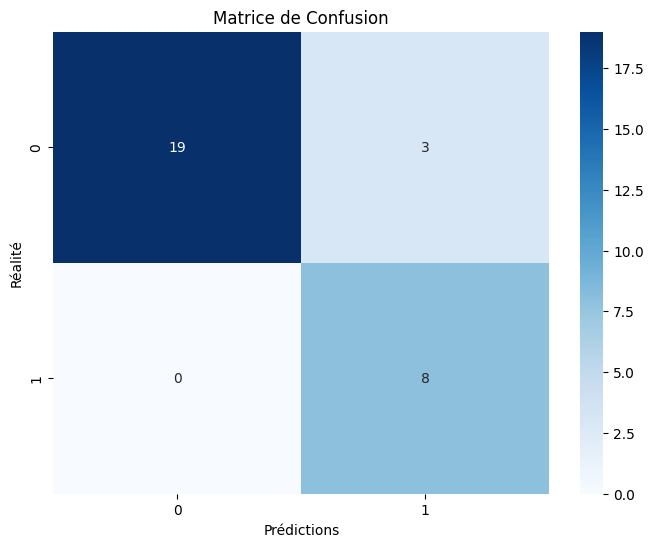

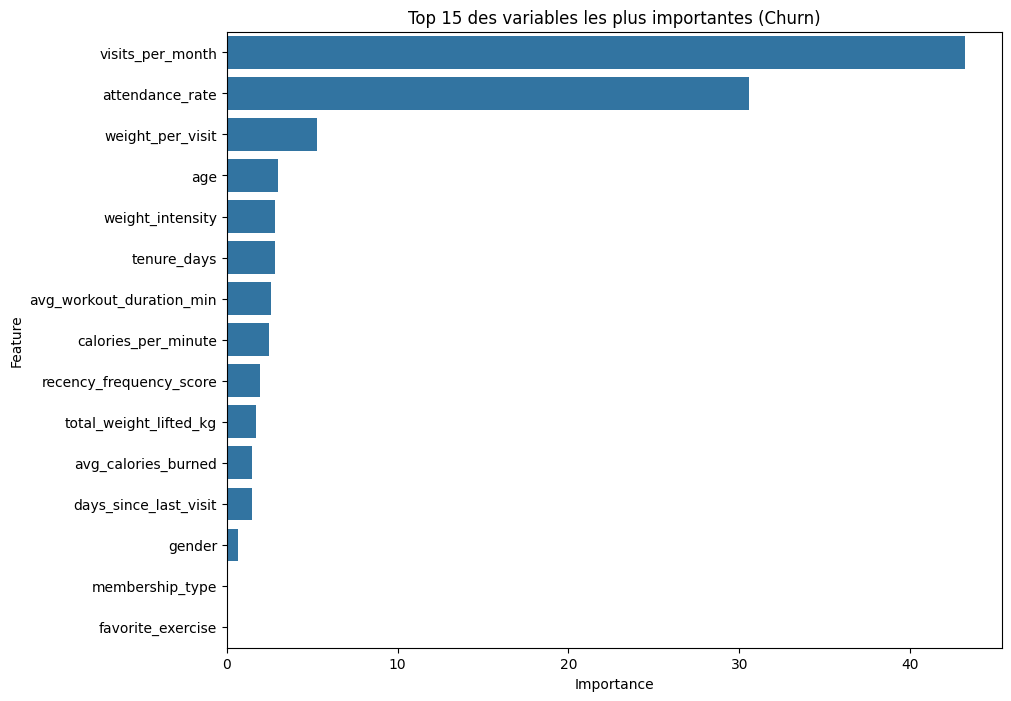

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prédictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 2. Rapport de classification (Précision, Rappel, F1-score)
print("--- Rapport de Classification ---")
print(classification_report(y_test, y_pred))

# 3. Score AUC (Capacité du modèle à distinguer les classes)
auc_score = roc_auc_score(y_test, y_proba)
print(f"Score ROC AUC: {auc_score:.4f}")

# 4. Matrice de Confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réalité')
plt.show()

# 5. Importance des Features
feature_importance = model.get_feature_importance(train_pool)
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15))
plt.title('Top 15 des variables les plus importantes (Churn)')
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame([f.__dict__ for f in feature_vectors])

y = df.pop("churn")
X = df.drop("member_id",axis=1)

categorical_cols = X.select_dtypes(exclude="number").columns.tolist()
print(categorical_cols)



from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

# Nettoyage avant le split
for col in X.columns:
    if col in categorical_cols:
        X[col] = X[col].fillna("Unknown").astype(str)
    else:
        X[col] = pd.to_numeric(X[col], errors='coerce') # Force en nombre, transforme les erreurs en NaN

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pool (devrait fonctionner maintenant)
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_cols)

# Train
model = CatBoostClassifier(iterations=500, verbose=100)
model.fit(train_pool, eval_set=test_pool)

# 1. Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Création des objets Pool
# C'est une structure de données propre à CatBoost qui optimise la mémoire et la vitesse
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_cols)

# 3. Initialisation du modèle
model = CatBoostClassifier(
    iterations=50,       # Nombre d'arbres
    learning_rate=0.1,     # Pas d'apprentissage
    depth=6,               # Profondeur des arbres
    loss_function='Logloss',
    verbose=100            # Affiche les résultats tous les 100 itérations
)

# 4. Entraînement (Train)
model.fit(
    train_pool,
    eval_set=test_pool,    # Permet de surveiller le surapprentissage sur le test set
    early_stopping_rounds=50 # Arrête l'entraînement si le score ne s'améliore plus
)

['gender', 'membership_type', 'favorite_exercise', 'visit_recency_bucket', 'tenure_bucket']


TypeError: must be real number, not NoneType

In [16]:
print(X.isna().sum()) # Affiche le nombre de valeurs manquantes par colonne

age                         13
avg_workout_duration_min     0
avg_calories_burned         11
total_weight_lifted_kg       8
visits_per_month            12
gender                       0
membership_type              0
favorite_exercise            0
tenure_days                  9
days_since_last_visit        0
visit_recency_bucket         0
tenure_bucket                9
calories_per_minute         11
weight_per_visit            18
dtype: int64
